In [1]:
import pandas as pd

data = pd.read_csv('Dados/projects.csv')
data.head()

,nao_finalizado,horas_esperadas,preco
0,0,75.0,6985.000000
1,1,0.0,4325.293458
2,0,87.0,14205.000000
3,1,13.0,100.000000
4,0,2.0,202.000000


In [2]:
# Aqui iremos inverter a lógica da coluna "não_finalizado" como "finalizado"
data['nao_finalizado'] = data['nao_finalizado'].map({1: 0, 0: 1})

# Aqui iremos renomear a coluna para "finalizado"
data.rename(columns={'nao_finalizado': 'finalizado'}, inplace=True)
data.head()

,finalizado,horas_esperadas,preco
0,1,75.0,6985.000000
1,0,0.0,4325.293458
2,1,87.0,14205.000000
3,0,13.0,100.000000
4,1,2.0,202.000000


Agora vamos analisar o como o preço e horas esperadas se relacionam.

Para isto, vamos plotar um gráfico de dispersão.

<Axes: xlabel='horas_esperadas', ylabel='preco'>

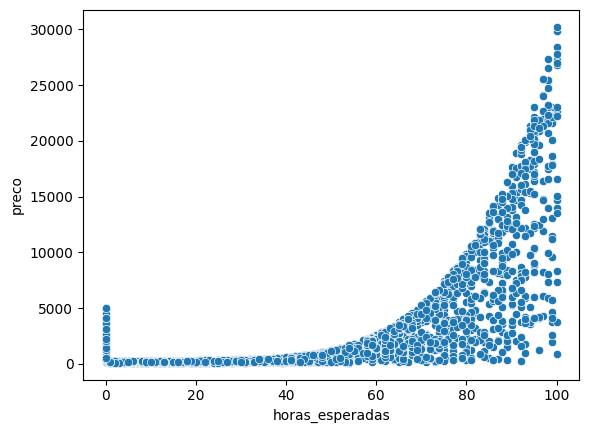

In [3]:
import seaborn as sns

sns.scatterplot(x='horas_esperadas', y='preco', data=data)

Neste gráfico podemos observar que há alguns dados que não fazem sentido, por exemplo:
- Em 0 horas esperadas, há alguns valores de preço que vão até 5 mil
- Em 100 horas esperadas, há alguns valores de preço que beiram a zero

Talvez seria interessante visualizarmos quais projetos foram finalizados ou não.

<Axes: xlabel='horas_esperadas', ylabel='preco'>

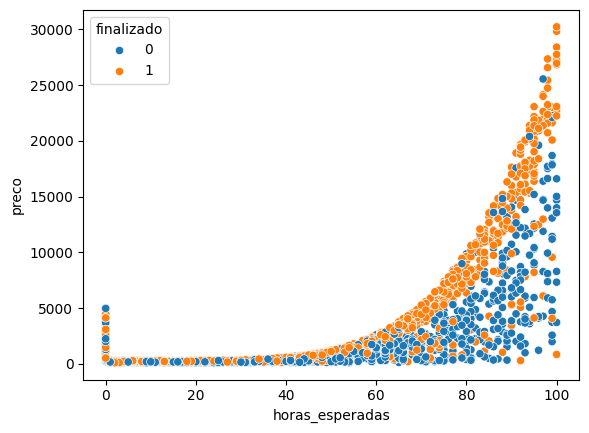

In [4]:
# Iremos colorir as bolinhas com base na propriedade "finalizado" com o parametro hue
sns.scatterplot(x='horas_esperadas', y='preco', data=data, hue='finalizado')

Faremos agora uma visualização separada entre os projetos que foram finalizados e os projetos não finalizados com a função *relplot* (relation plot).

Precisamos adicionar o parametro *col* para definir qual a propriedade que será considerada para essa relação.

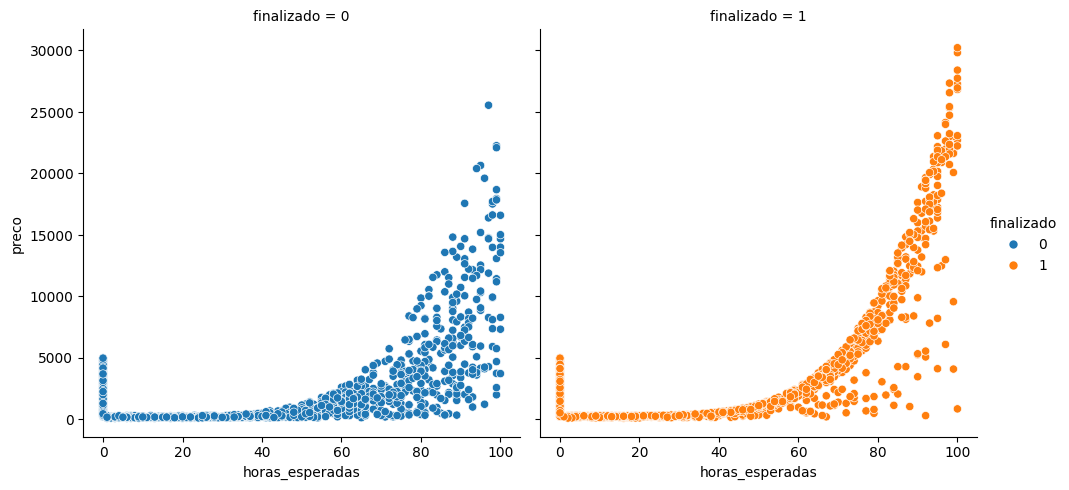

In [5]:
sns.relplot(x='horas_esperadas', y='preco', data=data, hue='finalizado', col='finalizado')

No gráfico da direita, que corresponde aos projetos que foram finalizados, ainda temos alguns dados estranhos, como para um projeto de 0 horas, o preço variar de 0 até 5000.

Talvez estes dados não seriam adequados mantermos para treinarmos nossa IA, então iremos remover todas as linhas com o preço zero (0). 

In [6]:
# Remover as linhas com horas_esperadas == 0
index_remove = data.query('horas_esperadas == 0').index

data.drop(index_remove, axis=0, inplace=True) # axis=0 indica que removerá linhas

# Também é possível fazer simplesmente assim:
# data.query('horas_esperadas > 0')

,finalizado,horas_esperadas,preco
0,1,75.0,6985.0
2,1,87.0,14205.0
3,0,13.0,100.0
4,1,2.0,202.0
5,1,49.0,1096.0
...,...,...,...
2451,1,87.0,11699.0
2452,1,96.0,21115.0
2453,0,1.0,172.0
2455,0,16.0,184.0


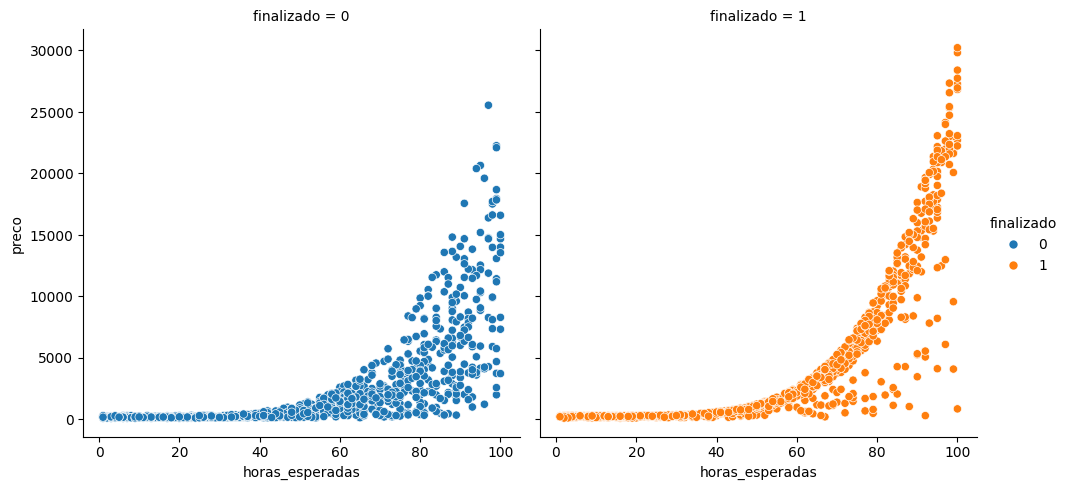

In [7]:
sns.relplot(x='horas_esperadas', y='preco', data=data, hue='finalizado', col='finalizado')
data

Agora iremos separar os dados de treinamento e testes.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separação de dados (características) dos rótulos (alvos)
X = data.drop('finalizado', axis=1)
y = data['finalizado']

# Separação em dados de treino e testes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20, stratify=y)

Antes de mandar os dados para treinar o nosso modelo, precisamos fazer com que todos os dados numéricos sejam normalizados para a mesma escala.

Esse processo se chama normalização (pré-processamento dos dados).

In [9]:
# Normalização dos dados de treino e teste
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

Vamos realizar o treinamento do nosso modelo, porém, para este caso, não usaremos mais o LinearSVC, pois este problema não condiz com uma situação linear. Esta é uma situação não linear.

Iremos utilizar o algoritmo SVM (Support Vector Machine) que é flexível tanto para problemas lineares quanto não lineares (SVC).

In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.svm import SVC

model = SVC()

# Treinamento do modelo
model.fit(X_train_scaled, y_train)

# Teste do modelo
model_predict = model.predict(X_test_scaled)

# Avaliação do modelo com as métricas
accuracy = accuracy_score(y_true=y_test, y_pred=model_predict)
print(f'Acurácia: {accuracy*100:.2f}%')

recall = recall_score(y_test, model_predict)
print(f'Recall: {recall*100:.2f}%')

precision = precision_score(y_test, model_predict)
print(f'Precisão: {precision*100:.2f}%')

f1_score_ = f1_score(y_test, model_predict)
print(f'F1 Score: {f1_score_*100:.2f}%')

Acurácia: 68.52%
Recall: 91.90%
Precisão: 63.97%
F1 Score: 75.43%


### Visualização da Curva de Decisão (Manual)

Este gráfico exibe a linha que divide o que o modelo considera como 0 (não finalizado) e como 1 (finalizado).

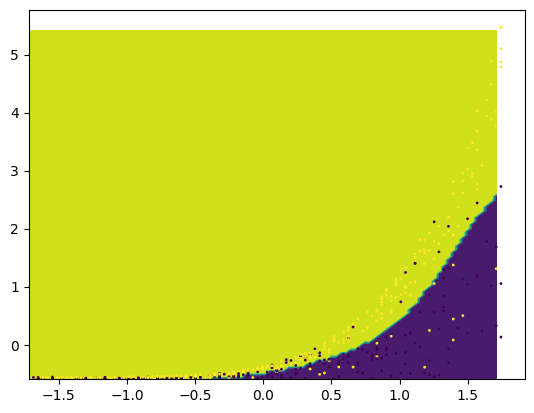

In [11]:
import matplotlib.pyplot as plt
import numpy as np

data_col1 = X_test_scaled[:, 0]
data_col2 = X_test_scaled[:, 1]

x_min = data_col1.min()
x_max = data_col1.max()
y_min = data_col2.min()
y_max = data_col2.max()

pixels = 100 # O fato de configurarmos apenas 100 pixels otimiza o tempo para exibição do gráfico

eixo_x = np.arange(x_min, x_max, (x_max - x_min) / pixels)
eixo_y = np.arange(y_min, y_max, (y_max - y_min) / pixels)

xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]

Z = model.predict(pontos)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z)
plt.scatter(data_col1, data_col2, c=y_test, s=1)

### Visualização da Curva de Decisão (Com a biblioteca mlxtend)

Esta biblioteca faz o cálculo da Curva de Decisão com uma função chamada *plot_decision_regions*, porém, dependendo da quantidade de dados, pode ser que demore um pouco para gera-lo.

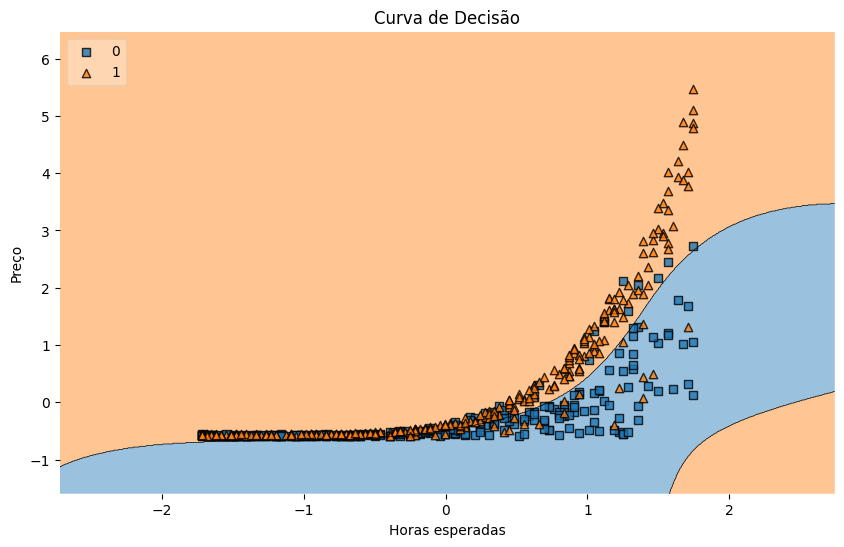

In [12]:
from mlxtend.plotting import plot_decision_regions

plt.figure(figsize=(10,6))
plot_decision_regions(X_test_scaled, y_test.to_numpy(), clf=model, legend=2)
plt.xlabel("Horas esperadas")
plt.ylabel("Preço")
plt.title("Curva de Decisão")
plt.show()